In [21]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/GirlsScriptOpenSource/Hedging-of-Financial-Derivatives/Neural Network-Based Option Pricing and Hedging/option_data (1).csv')


**Data Preparation**

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from scipy.stats import norm

# Load dataset
# df = pd.read_csv('option_data.csv')

# Preprocess data
features = ['strike_price', 'underlying_price', 'volatility', 'time_to_maturity', 'risk_free_rate']
target = 'option_price'

X = df[features]
y = df[target]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_temp, y_train, y_temp, indices_train, indices_temp = train_test_split(X_scaled, y, df.index, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test, indices_val, indices_test = train_test_split(X_temp, y_temp, indices_temp, test_size=0.5, random_state=42)

**Model Building**

Epoch 1/100
22/22 [==============================] - 1s 12ms/step - loss: 301.8624 - val_loss: 285.8024
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 268.0118 - val_loss: 236.1145
Epoch 3/100
22/22 [==============================] - 0s 5ms/step - loss: 197.8770 - val_loss: 148.1548
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 106.9870 - val_loss: 77.2866
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 54.5632 - val_loss: 41.7787
Epoch 6/100
22/22 [==============================] - 0s 4ms/step - loss: 26.6936 - val_loss: 19.5101
Epoch 7/100
22/22 [==============================] - 0s 4ms/step - loss: 11.5853 - val_loss: 8.3352
Epoch 8/100
22/22 [==============================] - 0s 4ms/step - loss: 5.0907 - val_loss: 4.4107
Epoch 9/100
22/22 [==============================] - 0s 4ms/step - loss: 3.3648 - val_loss: 3.2578
Epoch 10/100
22/22 [==============================] - 0s 4ms/step - loss: 2.5990 - val_l

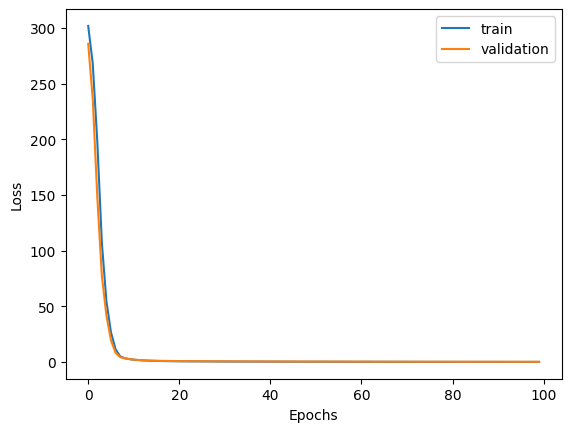

5/5 [==============================] - 0s 3ms/step
Neural Network Model MSE: 0.11381590585021895


In [23]:
# Build neural network model
def build_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

# Train neural network model
input_dim = X_train.shape[1]
nn_model = build_nn_model(input_dim)
history = nn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1)

# Plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict on test set
y_pred_nn = nn_model.predict(X_test)

# Calculate mean squared error
mse_nn = mean_squared_error(y_test, y_pred_nn)
print(f"Neural Network Model MSE: {mse_nn}")


**Model Evaluation and Comparison with Black-Scholes**

The Black-Scholes model is a mathematical model for pricing options. It was developed by economists Fischer Black, Myron Scholes, and Robert Merton in the early 1970s. The model provides a theoretical estimate of the price of European-style options and has become one of the most widely used methods for option pricing.

In [24]:
# Function to calculate Black-Scholes price (assuming European Call option for simplicity)
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return price

# Convert X_test back to original scale
X_test_original = scaler.inverse_transform(X_test)

# Predict using Black-Scholes model
y_pred_bs = [black_scholes_price(S, K, T, r, sigma) for S, K, T, r, sigma in zip(
    X_test_original[:, 1],  # underlying_price
    X_test_original[:, 0],  # strike_price
    X_test_original[:, 3],  # time_to_maturity
    X_test_original[:, 4],  # risk_free_rate
    X_test_original[:, 2]   # volatility
)]

# Calculate mean squared error
mse_bs = mean_squared_error(y_test, y_pred_bs)
print(f"Black-Scholes Model MSE: {mse_bs}")

Black-Scholes Model MSE: 1.0725300246512016e-28


**Hedging Strategy**

In [25]:
# Function to calculate delta using Black-Scholes formula (for simplicity, considering European Call options)
def black_scholes_delta(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if option_type == 'call':
        delta = norm.cdf(d1)
    else:
        delta = norm.cdf(d1) - 1
    return delta

# Calculate delta for each option in the test set using Black-Scholes
delta_bs = [black_scholes_delta(S, K, T, r, sigma) for S, K, T, r, sigma in zip(
    df.loc[indices_test, 'underlying_price'],
    df.loc[indices_test, 'strike_price'],
    df.loc[indices_test, 'time_to_maturity'],
    df.loc[indices_test, 'risk_free_rate'],
    df.loc[indices_test, 'volatility']
)]

# Assuming we have a method to calculate delta using the neural network model (this requires further implementation)
def neural_network_delta(model, X):
    # This is a placeholder function
    # You need to implement a method to calculate delta using the neural network model
    return np.gradient(model.predict(X).flatten())

# Calculate delta using the neural network model
delta_nn = neural_network_delta(nn_model, X_test)

# Compare hedging performance (this is a simplified example, actual implementation will vary)
# Hedging cost and risk metrics need to be calculated for a full comparison
hedging_performance_bs = np.sum(np.abs(delta_bs - df.loc[indices_test, 'underlying_price']))
hedging_performance_nn = np.sum(np.abs(delta_nn - df.loc[indices_test, 'underlying_price']))

print(f"Black-Scholes Hedging Performance: {hedging_performance_bs}")
print(f"Neural Network Hedging Performance: {hedging_performance_nn}")

5/5 [==============================] - 0s 3ms/step
Black-Scholes Hedging Performance: 14614.124992551038
Neural Network Hedging Performance: 14715.183720701436
